# Maximum weight independent set

In [notebook 04](https://github.com/aws/amazon-braket-examples/blob/main/examples/analog_hamiltonian_simulation/04_Maximum_Independent_Sets_with_Analog_Hamiltonian_Simulation.ipynb), we have illustrated how to solve the maximum independent set problem with Rydberg atoms. Here, we generalize the approach to solve the maximum weight independent set (MWIS) problem. The generalized approach utilizes the local detuning that detunes the atoms depending on the weights of the vertices in the graph, another important use case for local detuning. 

## Background: MWIS on a weighted unit disk graph

In this notebook, we consider the MWIS problem on a weighted unit disk graph. Recall that a unit disk graph is a graph in which any two vertices are connected if and only if they are within a unit disk of certain radius. As an example, let us consider the following 2D square lattice where the vertices are connected to their nearest neighbors.

![Blockade_examples_2D.png](Blockade_examples_2D.png)

This is an example of a unit disk graph where the radius is slightly larger than the lattice constant. To find the maximum independent set (MIS), one can map each vertex to a Rydberg atom such that neighboring atoms are blockaded by each other, as indicated by the overlapping circles in the above plot (note that the radius of the circles is half of the blockade radius of the Rydberg atoms). This guarantees that the pair of vertices connected by an edge cannot both be in the independent set. For this particular example, one can confirm that the MIS consists of vertices $\left\{0, 2, 4, 6, 8\right\}$, the black vertices in the plot.

A weighted unit disk graph is obtained by assigning weights onto the vertices of the unit disk graph. For instance, let us assign the following set of weights to the vertices

$$
w = [0.26, 0.13, 0.93, 0.95, 0.23, 0.20, 0.05, 0.96, 0.01].
$$


An MWIS for the weighted unit disk graph is an independent set with the largest total weights. It is important to note that the MWIS needs not be the same as the MIS for a given graph. For the example at hand, one can check that the MWIS consists of vertices $\left\{2, 3, 7\right\}$ with total weight $2.84$ which is larger than $1.48$, the weight for the MIS.

## Finding the MWIS with Rydberg atoms

The approach we will use to solve the MWIS problem is similar to that for the MIS problem, which is based on quantum adiabatic algorithm. In the beginning of the quantum evolution, we prepare the Hamiltonian in such a way that its many-body ground state has all atoms in the ground state $|g\rangle$. We then slowly turn on the global driving field, together with the local detuning. Particularly, we would like the Hamiltonian at the end of the evolution reads (see [notebook 00](https://github.com/aws/amazon-braket-examples/blob/main/examples/analog_hamiltonian_simulation/00_Introduction_of_Analog_Hamiltonian_Simulation_with_Rydberg_Atoms.ipynb) for the full Rydberg Hamiltonian)

\begin{align}
H_\text{final} =  -\sum_{k=1}^N \Delta_\text{local}w_k \,n_k + \sum_{j=1}^{N-1}\sum_{k = j+1}^N V_{j,k} \,n_j\, n_k,
\end{align}

where $\Delta_\text{local}>0$ and $w_k$ are the weights of the vertices. The last term ensures that we will arrive at an independent set, provided the evolution is adiabatic and neighboring atoms are within the blockade regime of each other. Since the first term favor the independent set that has the largest possible weight, we conclude that $H_\text{final}$ is the desired cost function, where the local detuning plays a fundamental role, for solving MWIS with the quantum adiabatic algorithm. 

In the implementation below, we will choose to ramp up the local detuning linearly from zero to a positive value, i.e., $\Delta_\text{local}(t_\text{initial})=0$ and $\Delta_\text{local}(t_\text{final})>0$. In order to make sure the initial ground state has all the atoms in $|g\rangle$, we will turn on a constant global detuning $\Delta_\text{global}\equiv\Delta_\text{global}(t_\text{initial})\equiv\Delta_\text{global}(t_\text{final})<0$ such that the net detuning for each atom starts from a positive value. The constant global detuning will not change the result of the MWIS because it acts on all the atoms uniformly and hence only changes the energy reference of $H_\text{final}$.


To begin, we import the necessary packages.

In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
tracker = Tracker().start()

In [2]:
from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.ahs.driving_field import DrivingField
from braket.ahs.local_detuning import LocalDetuning


from ahs_utils import show_register, show_drive_and_local_detuning, show_final_avg_density

import numpy as np
import matplotlib.pylab as plt

from braket.devices import LocalSimulator
simulator = LocalSimulator("braket_ahs")

Let's define certain constraints, such as maximum values for the Rabi frequency and local detuning.

In [3]:
omega_max = 15800000.0 # rad / seconds
omega_slew_rate_max = 250000000000000.0 # rad / seconds / seconds
tmin = 5e-08 # seconds

local_detuning_max = (2*np.pi*7.5)*1e6 # rad / seconds
local_detuning_slew_rate_max = (2*np.pi*7.5)*1e12 # rad / seconds / seconds

t_ramp_omega = omega_max/omega_slew_rate_max # seconds
t_ramp_local_detuning = local_detuning_max/local_detuning_slew_rate_max # seconds

detuning_max = 125000000.0 # rad / seconds

# Define atom arrangement

We define the 2D lattice of atoms as described above. 

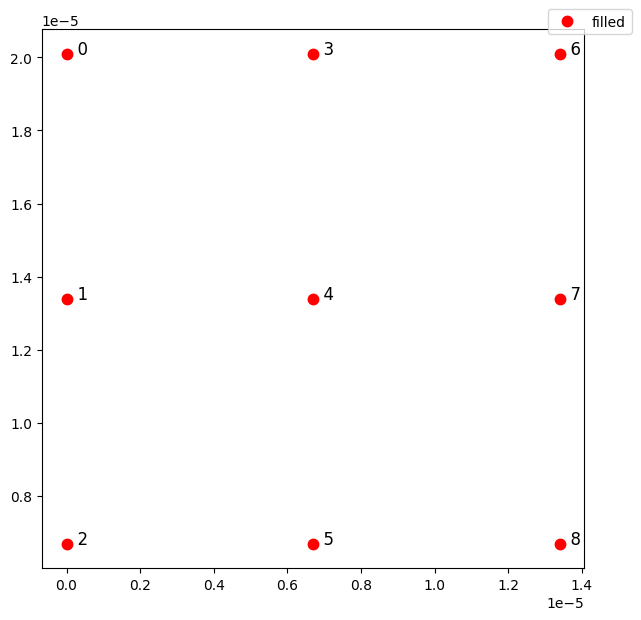

In [4]:
a = 6.7e-6
register = AtomArrangement()

for i in range(3):
    for j in range(3):
        register.add([i * a, (3-j) * a])
    
show_register(register)

## Solving MWIS with the help of local detuning

As described above, we now define an AHS program for solving the MWIS problem. The program consists of a local detuning that detunes the atoms according to the weights of the vertices, and a driving field that explores the possible solutions. 

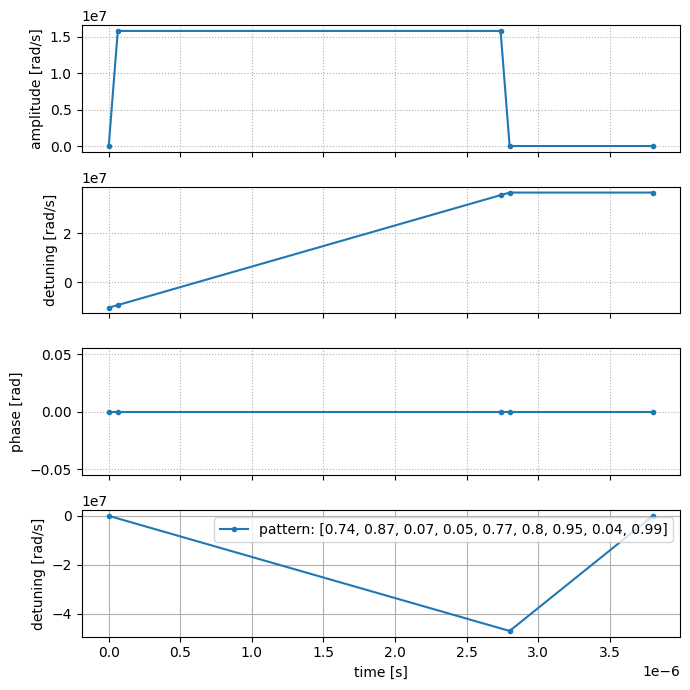

In [5]:
weights = [0.26, 0.13, 0.93, 0.95, 0.23, 0.20, 0.05, 0.96, 0.01] # Weights for the vertices in the graph

t_max = 3.8e-6


time_points = [0, t_ramp_omega, t_max - t_ramp_local_detuning - t_ramp_omega, t_max - t_ramp_local_detuning, t_max]
amplitude_values = [0, omega_max, omega_max, 0, 0]

phase_values = [0 for _ in range(len(time_points))]
detuning_0 = -detuning_max/12

detuning_slew_rate = local_detuning_max/(t_max - t_ramp_local_detuning)
detuning_values = [detuning_0, 
                   detuning_0 + detuning_slew_rate * t_ramp_omega,
                   detuning_0 + detuning_slew_rate * (t_max - t_ramp_local_detuning - t_ramp_omega),
                   detuning_0 + detuning_slew_rate * (t_max - t_ramp_local_detuning),
                   detuning_0 + detuning_slew_rate * (t_max - t_ramp_local_detuning)
                  ]

drive = DrivingField.from_lists(time_points, amplitude_values, detuning_values, phase_values)

time_local_detuning = [0, t_max - t_ramp_local_detuning, t_max]
value_local_detuning = [0, -local_detuning_max, 0]

pattern = [np.round(1-w, 2) for w in weights]
local_detuning = LocalDetuning.from_lists(time_local_detuning, value_local_detuning, pattern)


program = AnalogHamiltonianSimulation(
    hamiltonian=drive + local_detuning,
    register=register
)

show_drive_and_local_detuning(drive, local_detuning)

We can run the program on the local simulator and inspect the average final Rydberg densities.

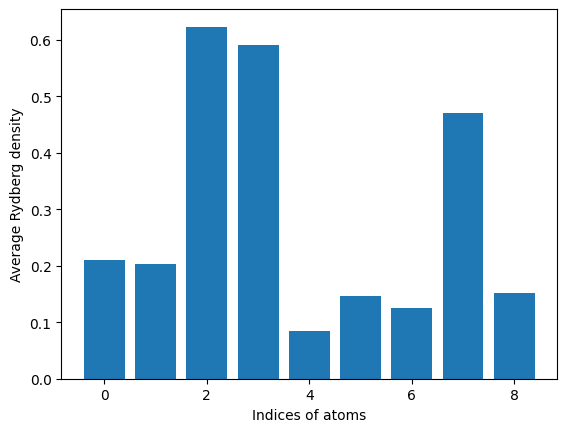

In [6]:
result = simulator.run(program, shots=1000, steps = 100).result()
show_final_avg_density(result)

From the above barplot, we see that vertices $\left\{2, 3, 7\right\}$ have the highest Rydberg densities around 0.5. This is precisely the MWIS for the given weighted unit disk graph. To further confirm that our protocol can yield the result of the correct MWIS, we aggregate over all the results, and find the most likely configuration. 

In [7]:
def get_counters_from_result(result):
    post_sequences = [list(measurement.post_sequence) for measurement in result.measurements]
    post_sequences = ["".join(['r' if site==0 else 'g' for site in post_sequence]) for post_sequence in post_sequences]

    counters = {}
    for post_sequence in post_sequences:
        if post_sequence in counters:
            counters[post_sequence] += 1
        else:
            counters[post_sequence] = 1
    return counters

counters = get_counters_from_result(result)
sorted_counters = sorted(counters.items(), key=lambda x: -x[1])


config_largest_prob = sorted_counters[0][0]
largest_prob = sorted_counters[0][1] / sum([item[1] for item in sorted_counters])

print(f"The configuration with largeset probability reads {config_largest_prob} with probability {largest_prob}")


The configuration with largeset probability reads ggrrgggrg with probability 0.243


The most likely configuration has Rydberg states for the vertices $\left\{2, 3, 7\right\}$, which again confirms that it corresponds to the MWIS of the given weighted unit disk graph. From the above simulation, there are around 24% of the chance we will obtain the correct MWIS. 

## Solving the MWIS problem on a QPU

In previous sections, we have demonstrated how to solve the MWIS problem with the Rydberg atoms. The results from the local simulator show that the results of the program meet our expectations. Here we will run the same AHS program on a quantum device.

<div class="alert alert-block alert-info">
<b>Note: </b> Since it will take sometime before we can receive the result back from the quantum device, it is suggested to save the task ARN for retrieving the task result in a later time. 
</div>

In [8]:
from braket.aws import AwsDevice 
qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")

In [9]:
task = qpu.run(program.discretize(qpu), shots=1000)
metadata = task.metadata()
task_arn = metadata['quantumTaskArn']
print(f"ARN: {task_arn}")

ARN: arn:aws:braket:us-east-1:545821822555:quantum-task/0a787c61-47f7-4237-81d3-2802891070ac


We can extract the result from the QPU and plot the average Rydberg density

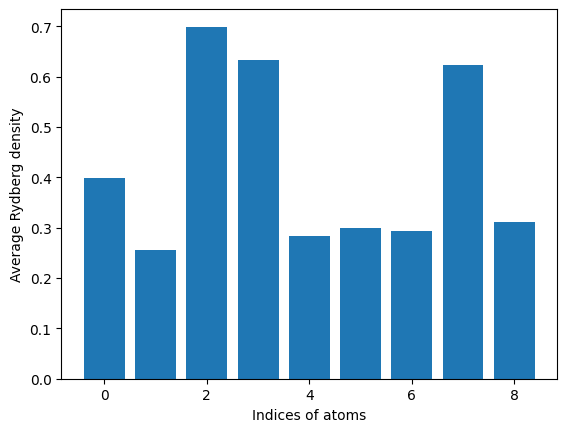

In [10]:
from braket.aws import AwsQuantumTask

task = AwsQuantumTask(arn=task_arn)
result_qpu = task.result()
show_final_avg_density(result_qpu)

In [11]:
counters_qpu = get_counters_from_result(result_qpu)
sorted_counters_qpu = sorted(counters_qpu.items(), key=lambda x: -x[1])

config_largest_prob_qpu = sorted_counters_qpu[0][0]
largest_prob_qpu = sorted_counters_qpu[0][1]/sum([item[1] for item in sorted_counters_qpu])

print(f"The configuration with largeset probability reads {config_largest_prob_qpu} with probability {largest_prob_qpu}")

The configuration with largeset probability reads ggrrgggrg with probability 0.129


## Conclusion

In this example, we have demonstrated how to solve the MWIS problem for a weighted unit disk graph. The local detuning plays the key role to enable one to define the cost function, which has different weights on different vertices. Given that the MWIS problem has many applications, such as routing, scheduling and network optimization, this example illustrates the potential of Rydberg atoms, together with the capability of local detuning, in different industries (see [Wurtz et. al](https://arxiv.org/abs/2205.08500) for more details).

In [12]:
print("Task Summary")
print(tracker.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {tracker.qpu_tasks_cost() + tracker.simulator_tasks_cost():.2f} USD")

Task Summary
{'arn:aws:braket:us-east-1::device/qpu/quera/Aquila': {'shots': 1000, 'tasks': {'COMPLETED': 1}}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 10.30 USD
